# NLP for digital humanities

Based on youtube series: https://www.youtube.com/watch?v=i74DVqMsRWY

This is cool: clustering meaning in extremely large texts. 

In a series of notebooks, I applied this and other approaches to *de grote word file* and *boris* his emails.

This first approach is basic. It focusses on `Tfidf > KMeans > TSNE`.

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import json, glob, re
import numpy as np
import numpy as np
from sklearn.manifold import TSNE
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import push_notebook
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

In [14]:
def load_data(file):
    with open (r'C:/Users/johan/Documents/GitHub/sandbox/'+ file, "r", encoding="utf-8") as f:
        return json.load(f)

def write_data(file, data):
    with open (r'C:/Users/johan/Documents/GitHub/sandbox/' + file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [15]:
def remove_stops(text, stops):
    text = re.sub(r"AC\/\d{1,4}\/\d{1,4}", "", text) # removes codes like AC/2000/142
    words = text.split()
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = " ".join(final)
    final = final.translate(str.maketrans("", "", string.punctuation))
    final = "".join([i for i in final if not i.isdigit()])
    while "  " in final:
        final = final.replace("  ", " ")
    return (final)

def clean_docs(docs):
    stops = stopwords.words("english")
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    stops = stops+months
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return (final)

In [19]:
descriptions = load_data("NLP/data/trc_dn.json")["descriptions"]
names = load_data("NLP/data/trc_dn.json")["names"]

In [20]:
descriptions[0], names[0]

("An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.",
 'AARON, Thabo Simon')

In [21]:
cleaned_docs = clean_docs(descriptions)

In [22]:
print(cleaned_docs[0])

An ANCYL member shot severely injured SAP members Lephoi Bethulie Orange Free State OFS Police opened fire gathering ANC supporters house following dispute two neighbours one linked ANC SAP councillor


In [23]:
vectorizer = TfidfVectorizer(lowercase=True,
                            max_features=100,
                            max_df=0.8,
                            min_df=5,
                            ngram_range = (1,3),
                            stop_words = "english"
                            )

vectors = vectorizer.fit_transform(cleaned_docs)

feature_names = vectorizer.get_feature_names_out()

denselist = vectors.todense().tolist()

all_keywords = []

for description in denselist:
    # x=0
    keywords = []
    for x, word in enumerate(description):
        if word > 0:
            keywords.append(feature_names[x])
        # x+=1
    all_keywords.append(keywords)
    
print(descriptions[0])
print(all_keywords[0])

An ANCYL member who was shot and severely injured by SAP members at Lephoi, Bethulie, Orange Free State (OFS) on 17 April 1991. Police opened fire on a gathering at an ANC supporter's house following a dispute between two neighbours, one of whom was linked to the ANC and the other to the SAP and a councillor.
['anc', 'anc supporters', 'house', 'injured', 'member', 'members', 'police', 'sap', 'severely', 'shot', 'supporters']


In [24]:
true_k = 20

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)

model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]

In [25]:
for i in range(true_k):
    print(f"Cluster {i}")
    for ind in order_centroids[i, :10]:
        print('- ', feature_names[ind])


Cluster 0
-  bophuthatswana
-  police
-  members
-  beaten
-  severely
-  severely beaten
-  arrested
-  tvl
-  assaulted
-  detained
Cluster 1
-  ifp
-  supporters
-  anc
-  ifp supporters
-  anc supporters
-  natal
-  supporter
-  stabbed
-  death
-  near
Cluster 2
-  kwamashu
-  kwamashu durban
-  durban
-  near
-  conflict
-  supporters
-  burnt
-  political conflict
-  political
-  anc
Cluster 3
-  amnesty
-  granted
-  granted amnesty
-  injured
-  perpetrators
-  anc
-  killed
-  member
-  members
-  transvaal
Cluster 4
-  sonkombo
-  ndwedwe
-  ndwedwe kwazulu near
-  ndwedwe kwazulu
-  kwazulu near durban
-  near durban
-  arson
-  attacks
-  kwazulu near
-  kwazulu
Cluster 5
-  members sap
-  sap
-  members
-  shot
-  cape
-  police
-  shot dead
-  dead
-  injured
-  soweto
Cluster 6
-  arson attack
-  arson
-  attack
-  lost
-  home
-  house
-  destroyed
-  supporters
-  anc
-  conflict
Cluster 7
-  empangeni
-  empangeni natal
-  natal
-  kwazulu
-  ifp
-  kwazulu near
-  n

## Visualisation

Both t-SNE (t-distributed Stochastic Neighbor Embedding) and PCA (Principal Component Analysis) are dimensionality reduction techniques, but they have distinct differences, especially when used in conjunction with clustering algorithms like k-means. Here are the key differences between the two, especially in the context of visualization and k-means clustering:

1. **Algorithmic Foundation**:
   - **PCA**: PCA is a linear dimensionality reduction technique that seeks to maximize variance and preserve large pairwise distances in the reduced space. It identifies the "principal components" or directions in which the data varies the most.
   - **t-SNE**: t-SNE is a non-linear dimensionality reduction technique that works by trying to preserve the local structure of the data. It minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

2. **Visualization Intuition**:
   - **PCA**: Because it's linear, PCA may not be able to capture complex intrinsic structures in the data. It's good for preserving global structure but might not capture local groupings effectively.
   - **t-SNE**: Being non-linear, t-SNE is better at capturing and representing local structures in the data, making it more suitable for visualizing clusters or groupings in the data.

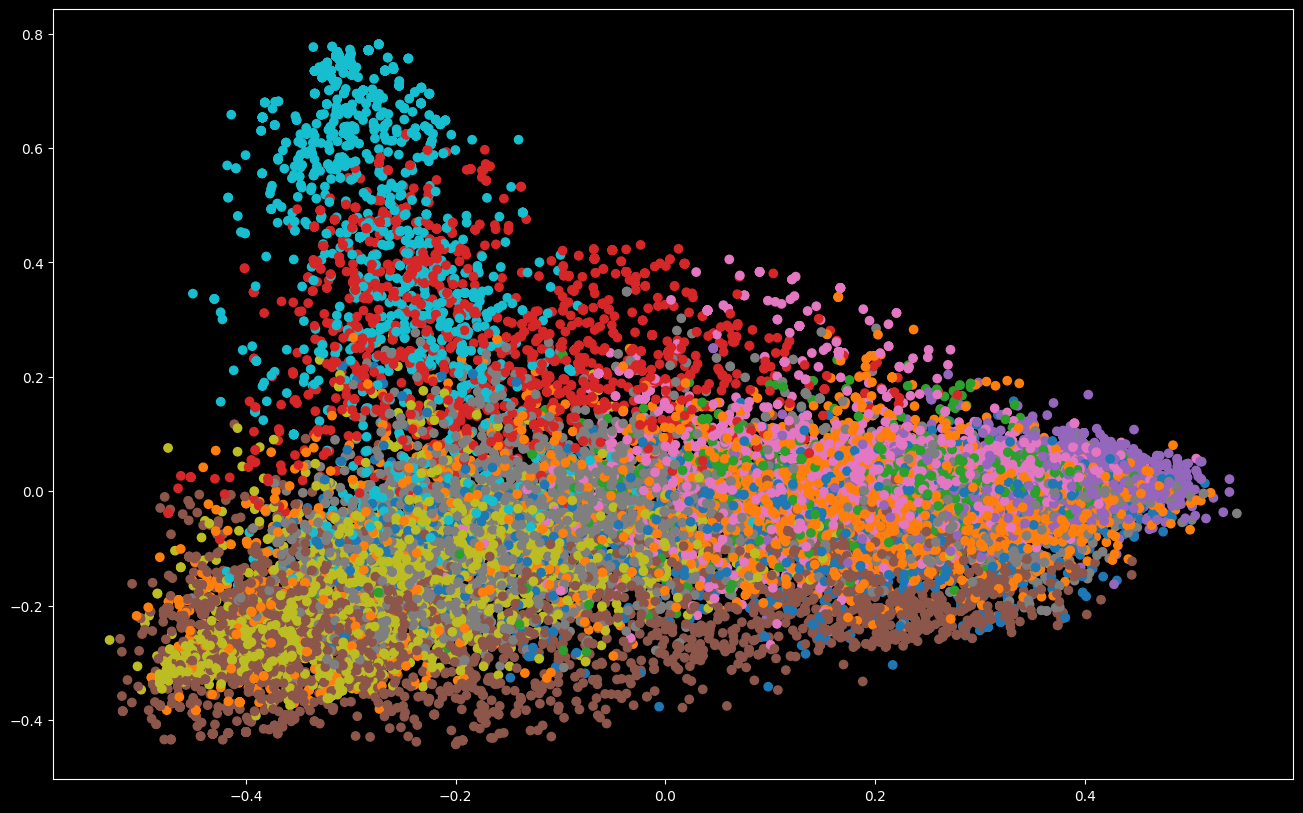

In [28]:
from sklearn.decomposition import PCA

kmean_indices = model.fit_predict(vectors)

pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(np.array(vectors.todense()))

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]

fig, ax = plt.subplots(figsize=(16,10))

ax.scatter(x_axis, y_axis, c=mycolors[labels % len(mycolors)])

# for i, txt in enumerate(names):
#     ax.annotate(txt[0:5], (x_axis[i], y_axis[i])) 

In [66]:
# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, perplexity=60, init='auto')
low_dim_data = tsne_model.fit_transform(np.array(vectors.todense()))

# Retrieve the labels assigned by KMeans
labels = model.labels_

In [67]:
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

source = ColumnDataSource(data=dict(
    x=low_dim_data[:, 0],
    y=low_dim_data[:, 1],
    colors=mycolors[labels % len(mycolors)],
    descriptions=[desc[:100] for desc in descriptions]
))

hover = HoverTool(tooltips = [("description", "@descriptions")])

plot = figure(tools="pan, wheel_zoom, reset", title=f"t-SNE Clustering of {true_k} KMeans Topics", width=1200, height=800)

plot.add_tools(hover)

plot.scatter('x', 'y', source=source, color='colors')

# Show plot
show(plot)